In [2]:
#Imports and API Key
#building in offsets

#checkout scikit learn timeseries 
#checkout cross validation - rolling window

#Imports and API Key

import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

import sys
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from xgboost import plot_importance

%aimport dataclean

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

from xgboost import plot_importance

In [3]:
#pulling data from Quandl

data = pd.read_csv('datasources2.csv') #staging the QUANDL keys to pull in CSV
cols = list(data['Var_name'].astype('str'))
dataset = quandl.get([val for val in data['Quandl Key']]) #looping through the QUANDL keys to pull it into one DF
dataset.columns = cols

In [4]:
#pulling FED Yield Curve data

yields = pd.read_csv('Fed10Y_3M.csv')
yields['Date'] = pd.to_datetime(yields['Date'])
mask = (yields['Date'] > pd.datetime(2058,1,1))
yields.loc[mask,'Date'] = yields.loc[mask,'Date'].apply(lambda x: x - pd.DateOffset(years=100))

yields['Date'] = yields['Date'].apply(lambda x: x.strftime('%Y-%m'))

yields = yields.set_index('Date')
yields = yields.drop(['3 Month Treasury Yield', 'Rec_prob', 'NBER_Rec'], axis=1) 

In [5]:
#need to write in special logic to factor in for 3YRT being a daily

treas = dataset['3YRT']
dataset = dataset.drop(columns = ['3YRT'])

In [6]:
treas = treas.resample('MS').mean()

In [7]:
## back to working on the general data
dataset.index = dataset.index.strftime('%Y-%m') #converting the datetime index to Y/M so it is collapsable
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum) #collapsing by Y/M

In [8]:
#readd 3YRT back into data

dataset = dataset.join(treas, how='outer')

In [9]:
#converting GDP quarterly data into monthly - need to convert it so it fills in the following 3 months

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [10]:
offset_dict = {'PMI':1, 'UNR':1, 'YUNR':1,'US_NHOME_SALES':1, 'PART_TIME':1, 'CPPR_PRICE':1, 'HOUS_PERMS':1, 'HOUS_STARTS':1, 'CAP_UTIL':1, 'PERS_SAVINGS':3, 'EXPORTS':3, 'IMPORTS':3, 'TRADE_BALANCE':3, 'US_M2':1, 'US_NHOME_SALES':1,'PPI':1,'CPI':1} #positives shift down, negatives shift up. Goal of this dict is to align data to when it gets released

In [11]:
for entry in offset_dict:
    #print(entry)
    #print(offset_dict[entry])
    dataset[str(entry)] = dataset[str(entry)].shift(offset_dict[entry])

In [12]:
#calculating change in GDP and converting Y into categorical values 
dataset['Recession'] = ((dataset['GDP'] - dataset['GDP'].shift(3)) < 0).astype(int)
dataset = dataset.drop(columns = ['GDP']) #dropping calc column and recession column from dataset, experimenting with taking out fed funds rate

In [13]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [14]:
dataset = dataset[552:]

In [15]:
dataset = dataset[:-11]

In [16]:
#substituting mean value in for missing values and adding dummy column to indicate where done.

#could be data leakage here, need to revise this function so it's only backward looking

for col in dataset.columns:
    if str(col)=='Recession':
        continue
    dataclean.clean_zeros(col, dataset)

In [17]:
dataset['3YRT'] = dataset['3YRT'].fillna(dataset['3YRT'].mean())

In [18]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')
momentum_cols.remove('Recession')

for i in [1,3,12]:
    for col in momentum_cols:
        if 'PXY' in str(col): #adding logic so it doesn't create a momentum column out of PXY columns
            continue
        dataclean.create_momentum(col,dataset,i)

In [19]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [20]:
#cutoff most of missing data, Post March 2019, Prior 1959. CPI/PPI missing 2016 onward so need to cut that off
#dataset = dataset.iloc[552:]
#dataset = dataset.iloc[:-2]

#y = y.iloc[552:]
y = dataset['Recession']
dataset = dataset.drop(columns = ['Recession'])
X = dataset

In [21]:
### Data Prep Finished Here ###

In [22]:
time = [0,-1,-3,-12]
result1 = pd.DataFrame(y.iloc[550:723].values)
result1.index = y.iloc[550:723].index

params = {0:[4,0.005,500],-1:[5,0.005,500],-3:[10,0.01,300],-12:[1,0.001,1500]}

for point in time:
    
    model = xgb.XGBClassifier(learning_rate=params[point][1],
                                   n_estimators=params[point][2], #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=params[point][0],
                                   subsample=0.5)
    
    X = dataset
    
    y_shift = y.shift(point) #needs to be negative to look forward
    y_shift = y_shift.fillna(0)
    
    X_train = X.iloc[12:550]
    X_test = X.iloc[550:723]
    y_train = y_shift.iloc[12:550]
    y_test = y_shift.iloc[550:723]
    
    #model = LogisticRegression(penalty = 'l2', C=2000, max_iter = 100, solver = 'sag') #try throwing in a bigger C than 1
    #RidgeClassifier().fit(X, y)
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)
    
    result1[str(point)] = probs[:,1]
    
    #print(probs[:,1])
    

In [23]:
result1 = result1.drop(columns = 0)

In [24]:
result1.columns = ['Current Month','1 Month Horizon','3 Month Horizon','12 Month Horizon']

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

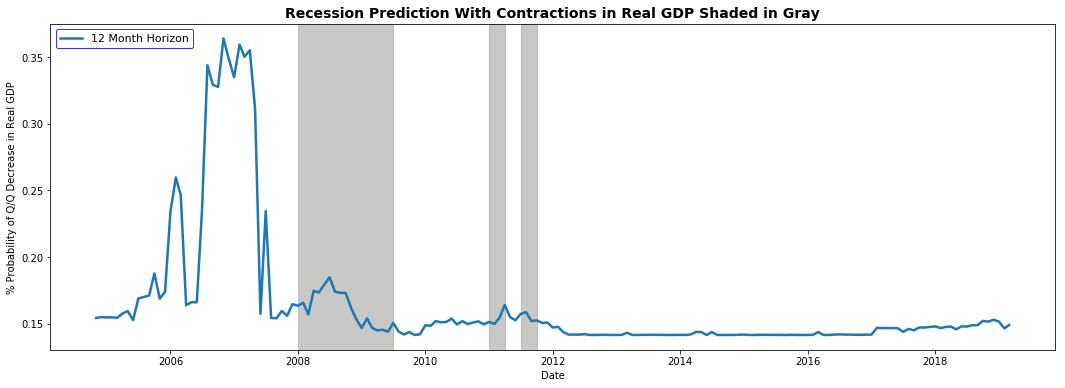

In [25]:
x = result1.index
a = result1.iloc[:,0]
b = result1.iloc[:,1]
c = result1.iloc[:,2]
d = result1.iloc[:,3]

fig, ax = plt.subplots(figsize=(18, 6))
#ax.plot(x, a, linewidth=2.5, zorder=2)
#ax.plot(x, b, linewidth=2.5, zorder=2)
#ax.plot(x, c, linewidth=2.5, zorder=2)
ax.plot(x, d, linewidth=2.5, zorder=2)
ax.scatter(x, d, s=0, zorder=1, label='_nolegend_')
ax.axvspan(x[38],x[56], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[74],x[77], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[80],x[83], color=sns.xkcd_rgb['grey'], alpha=0.5)

ax.set_title('Recession Prediction With Contractions in Real GDP Shaded in Gray', fontsize=14, fontweight='demi')

ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')

ax.set_ylabel('% Probability of Q/Q Decrease in Real GDP')
ax.set_xlabel('Date')

In [26]:
result1.head()

,Current Month,1 Month Horizon,3 Month Horizon,12 Month Horizon
2004-11-01,0.048269,0.059076,0.067288,0.154445
2004-12-01,0.061321,0.074639,0.070041,0.155153
2005-01-01,0.053577,0.097497,0.084445,0.154880
2005-02-01,0.051860,0.073498,0.067991,0.154938
2005-03-01,0.062600,0.074146,0.082246,0.154558


In [27]:
X = dataset

In [28]:
y_shift = y.shift(-12) #needs to be negative to look forward
y_shift = y_shift.fillna(0)

In [29]:
X_train = X.iloc[12:550]
X_test = X.iloc[550:723]
y_train = y_shift.iloc[12:550]
y_test = y_shift.iloc[550:723]

In [30]:
model = xgb.XGBClassifier(learning_rate=0.001,
                                   n_estimators=1500, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=1, min_child_weight=1, min_samples_leaf=4, missing=None,
       n_estimators=1500, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.5)

In [31]:
probs = model.predict_proba(X_test)

In [32]:
log_loss(y_test, probs)

0.39334529173167454

In [33]:
roc_auc_score(y_test.values, probs[:,1:])

0.7269295302013421

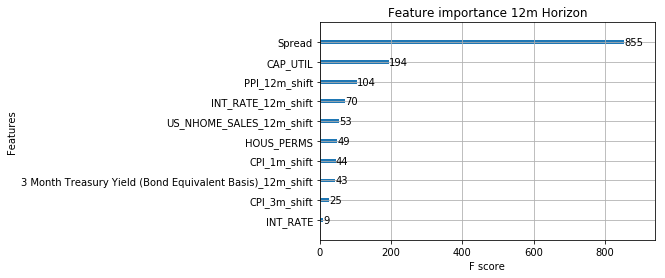

In [34]:
plot_importance(model, max_num_features = 10, title='Feature importance 12m Horizon')

In [35]:
probs

array([[0.8455546 , 0.15444542],
       [0.8448466 , 0.15515336],
       [0.8451196 , 0.15488042],
       [0.84506226, 0.15493776],
       [0.84544194, 0.15455803],
       [0.8422223 , 0.15777771],
       [0.8403376 , 0.15966243],
       [0.84718406, 0.15281592],
       [0.83096516, 0.16903487],
       [0.82981944, 0.17018056],
       [0.8286836 , 0.17131637],
       [0.8121897 , 0.18781029],
       [0.8310739 , 0.16892612],
       [0.8259567 , 0.17404331],
       [0.7658099 , 0.2341901 ],
       [0.74028647, 0.25971356],
       [0.7534347 , 0.2465653 ],
       [0.8359665 , 0.16403347],
       [0.83370876, 0.1662912 ],
       [0.833779  , 0.166221  ],
       [0.76474565, 0.23525435],
       [0.656181  , 0.343819  ],
       [0.6707654 , 0.3292346 ],
       [0.6724242 , 0.32757577],
       [0.63606846, 0.3639315 ],
       [0.6511885 , 0.34881148],
       [0.66513216, 0.33486784],
       [0.6406249 , 0.35937515],
       [0.6498035 , 0.35019648],
       [0.64490306, 0.35509697],
       [0.

In [36]:
results = pd.DataFrame(probs)
results['actual'] = y_test.values
results.index = y_test.index
pd.set_option('display.float_format', lambda x: '%.3f' % x)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(results)

               0     1  actual
2004-11-01 0.846 0.154   0.000
2004-12-01 0.845 0.155   0.000
2005-01-01 0.845 0.155   0.000
2005-02-01 0.845 0.155   0.000
2005-03-01 0.845 0.155   0.000
2005-04-01 0.842 0.158   0.000
2005-05-01 0.840 0.160   0.000
2005-06-01 0.847 0.153   0.000
2005-07-01 0.831 0.169   0.000
2005-08-01 0.830 0.170   0.000
2005-09-01 0.829 0.171   0.000
2005-10-01 0.812 0.188   0.000
2005-11-01 0.831 0.169   0.000
2005-12-01 0.826 0.174   0.000
2006-01-01 0.766 0.234   0.000
2006-02-01 0.740 0.260   0.000
2006-03-01 0.753 0.247   0.000
2006-04-01 0.836 0.164   0.000
2006-05-01 0.834 0.166   0.000
2006-06-01 0.834 0.166   0.000
2006-07-01 0.765 0.235   0.000
2006-08-01 0.656 0.344   0.000
2006-09-01 0.671 0.329   0.000
2006-10-01 0.672 0.328   0.000
2006-11-01 0.636 0.364   0.000
2006-12-01 0.651 0.349   0.000
2007-01-01 0.665 0.335   1.000
2007-02-01 0.641 0.359   1.000
2007-03-01 0.650 0.350   1.000
2007-04-01 0.645 0.355   0.000
2007-05-01 0.689 0.311   0.000
2007-06-

In [43]:
#Grid Search

max_depth = [1,2,3,4,5,7,10]
n_est = [100, 200, 300,500, 1000,1500,2000]
learning_rate = [0.001,0.005,0.010]

hyperparams = pd.DataFrame(columns = ['Max_Depth','N_Est','Learning_Rate','Log_Loss','AUC'])


for depth in max_depth:
    for n in n_est:
        for r in learning_rate:

            model = xgb.XGBClassifier(learning_rate=r,
                                       n_estimators=n, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                       min_samples_leaf=4,
                                       max_depth=depth,
                                       subsample=0.5)
            model.fit(X_train, y_train) #fitting model
            probs = model.predict_proba(X_test)
            ll = log_loss(y_test, probs)
            auc = roc_auc_score(y_test.values, probs[:,1:])
            
            hyps = {'Max_Depth': depth,
                                'N_Est':n,
                                'Learning_Rate':r,
                                'Log_Loss':ll,
                                'AUC':auc}
            
            hyperparams = hyperparams.append(hyps, ignore_index=True)
            
            #print("Testing max depth {}, learning rate {} and n_est of {}, yielding log loss of {} and AUC of {}".format(depth,r, n, ll, auc))

KeyboardInterrupt: 

In [44]:
hyperparams

,Max_Depth,N_Est,Learning_Rate,Log_Loss,AUC
0,1.000,100.000,0.001,0.636,0.611
1,1.000,100.000,0.005,0.493,0.600
2,1.000,100.000,0.010,0.419,0.678
3,1.000,200.000,0.001,0.589,0.667
4,1.000,200.000,0.005,0.419,0.690
5,1.000,200.000,0.010,0.391,0.719
6,1.000,300.000,0.001,0.551,0.688
7,1.000,300.000,0.005,0.393,0.724
8,1.000,300.000,0.010,0.401,0.714
9,1.000,500.000,0.001,0.494,0.703


In [45]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)

1959-01-01   0.000
1959-02-01   0.000
1959-03-01   0.000
1959-04-01   0.000
1959-05-01   0.000
1959-06-01   0.000
1959-07-01   0.000
1959-08-01   0.000
1959-09-01   0.000
1959-10-01   0.000
1959-11-01   0.000
1959-12-01   0.000
1960-01-01   0.000
1960-02-01   0.000
1960-03-01   0.000
1960-04-01   1.000
1960-05-01   1.000
1960-06-01   1.000
1960-07-01   0.000
1960-08-01   0.000
1960-09-01   0.000
1960-10-01   1.000
1960-11-01   1.000
1960-12-01   1.000
1961-01-01   0.000
1961-02-01   0.000
1961-03-01   0.000
1961-04-01   0.000
1961-05-01   0.000
1961-06-01   0.000
1961-07-01   0.000
1961-08-01   0.000
1961-09-01   0.000
1961-10-01   0.000
1961-11-01   0.000
1961-12-01   0.000
1962-01-01   0.000
1962-02-01   0.000
1962-03-01   0.000
1962-04-01   0.000
1962-05-01   0.000
1962-06-01   0.000
1962-07-01   0.000
1962-08-01   0.000
1962-09-01   0.000
1962-10-01   0.000
1962-11-01   0.000
1962-12-01   0.000
1963-01-01   0.000
1963-02-01   0.000
1963-03-01   0.000
1963-04-01   0.000
1963-05-01  

In [46]:
print(sum(y))

84.0


In [47]:
X_train

,PMI,UNR,YUNR,CONS_SENT,PART_TIME,CPPR_PRICE,HOUS_PERMS,HOUS_STARTS,CAP_UTIL,PERS_SAVINGS,...,3YRT_12m_shift,10 Year Treasury Yield_12m_shift,3 Month Treasury Yield (Bond Equivalent Basis)_12m_shift,Spread_12m_shift,CPI_1m_shift,PPI_1m_shift,CPI_3m_shift,PPI_3m_shift,CPI_12m_shift,PPI_12m_shift
1960-01-01,58.200,5.300,11.100,93.800,1000.000,165.685,1329.334,1601.000,69.397,9.400,...,0.000,0.700,1.580,-0.880,0.000,0.000,0.341,-0.631,1.730,-0.316
1960-02-01,61.500,5.200,10.900,93.800,1015.000,165.685,1092.000,1460.000,69.397,10.100,...,0.000,0.530,1.300,-0.770,-0.340,0.317,-0.340,0.000,1.034,-0.315
1960-03-01,52.300,4.800,10.200,93.800,1062.000,165.685,1088.000,1503.000,69.397,11.000,...,0.000,0.260,0.520,-0.260,0.341,0.000,0.000,0.317,1.730,-0.315
1960-04-01,47.800,5.400,11.500,93.800,888.000,165.685,955.000,1109.000,69.397,10.900,...,0.000,0.160,0.290,-0.130,0.000,0.633,0.000,0.952,1.730,0.315
1960-05-01,45.300,5.200,10.900,93.300,1041.000,165.685,1016.000,1289.000,69.397,10.600,...,0.000,0.040,0.460,-0.420,0.340,0.000,0.683,0.633,1.724,0.000
1960-06-01,42.600,5.100,10.700,93.300,988.000,165.685,1052.000,1271.000,69.397,9.400,...,0.000,-0.190,-0.770,0.580,0.000,-0.314,0.340,0.316,1.724,-0.314
1960-07-01,44.400,5.400,11.000,93.300,966.000,165.685,958.000,1247.000,69.397,8.400,...,0.000,-0.500,-0.920,0.420,0.339,0.000,0.680,-0.314,1.718,0.000
1960-08-01,43.700,5.500,10.800,97.200,1013.000,165.685,999.000,1197.000,69.397,10.400,...,0.000,-0.630,-1.110,0.480,0.000,0.000,0.339,-0.314,1.370,0.000
1960-09-01,47.600,5.600,11.400,97.200,1018.000,165.685,994.000,1344.000,69.397,10.400,...,0.000,-0.880,-1.610,0.730,0.000,-0.315,0.339,-0.315,1.370,0.000
1960-10-01,45.400,5.500,11.000,97.200,1027.000,165.685,984.000,1097.000,69.397,10.400,...,0.000,-0.640,-1.800,1.160,0.000,0.000,0.000,-0.315,1.024,-0.315


In [48]:
model.feature_importances_

XGBoostError: need to call fit or load_model beforehand

In [49]:
plot_importance(model, max_num_features = 10, title = 'Feature Importance for Predicting Contractions in Real GDP 12 Months Out')

XGBoostError: need to call fit or load_model beforehand

In [50]:
for combo in zip(X_train.columns,model.feature_importances_):
    print(combo)

XGBoostError: need to call fit or load_model beforehand

In [ ]:
importance = pd.DataFrame(zip(X_train.columns,model.feature_importances_), columns = ['Indicator','Importance'])

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(importance.sort_values(['Importance'], ascending = False))

In [ ]:
X_train.head(100)

In [ ]:
X = X.iloc[12:]
y = y.iloc[12:]

In [ ]:
tscv = TimeSeriesSplit(n_splits=4)

In [ ]:
TimeSeriesSplit(max_train_size=None, n_splits=4)

In [ ]:
for train_index, test_index in tscv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    #print(X_train, y_train)
    
    
    model = xgb.XGBClassifier(learning_rate=0.005,
                                   n_estimators=1000, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                   min_samples_leaf=4,
                                   max_depth=1,
                                   subsample=0.5)

    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)
    
    #print(probs)
    
    print(log_loss(y_test, probs))
    
    print(roc_auc_score(y_test.values, probs[:,1:]))
    
    results = pd.DataFrame(probs)
    results['actual'] = y_test.values
    results.index = y_test.index
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(results)
    

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(y)

In [ ]:
#Grid Search

max_depth = [1,2,3,4,5,7,10]
n_est = [100, 200, 300,500, 1000,1500,2000]
learning_rate = [0.001,0.005,0.010]

for depth in max_depth:
    for n in n_est:
        for r in learning_rate:

            model = xgb.XGBClassifier(learning_rate=r,
                                       n_estimators=n, #bump this and learning rate to make more trees, trees(not exact) = n*learning rate
                                       min_samples_leaf=4,
                                       max_depth=depth,
                                       subsample=0.5)
            model.fit(X_train, y_train) #fitting model
            probs = model.predict_proba(X_test)
            ll = log_loss(y_test, probs)
            auc = roc_auc_score(y_test.values, probs[:,1:])
            print("Testing max depth {}, learning rate {} and n_est of {}, yielding log loss of {} and AUC of {}".format(depth,r, n, ll, auc))

In [92]:
y_test.sum()

24.0